In [1]:
%load_ext autoreload
%autoreload 2

# Systematically Improving RAG

# When should we fine-tune an embedding model?

> If you haven't, please make sure that you've ran `1. Synthethic Transactions.ipynb` and `2. Finetune Cohere.ipynb` first before proceeding with this section. This will ensure that you have all of the necessary data and models to follow along.

In this notebook, we'll explore how to fine-tune an open source embedding model. We want to explore fine-tuning ideally when we have more data because we're training our model to learn a new mapping from our data. Ideally we'd start with fine-tuning the cross encoder first before considering fine-tuning a embedding model.

We use `sentence-transformers` because it provides a large variety of loss functions out of the box and is compatible with Hugging Face, making it easy to upload and save the fine-tuned models when we're done. 

# Setup

In this section, we'll be fine-tuning the `BAAI/bge-base-en` model. We'll be using the `BatchSemiHardTripletLoss` loss function to train our model. 


A Batch Semi Hard Triplet Loss works by taking a batch of sentence pairs and computing the loss for all possible valid triplets, then identifying semi-hard positives and negatives. A semi-hard negative is an example that is not as close to the anchor as the positive example, but is still closeer to the anchor than the negative example. 

<img src = "./data/semi-hard-negative.png" width = 500 />

Using the original Cohere dataset format, 

- `query` : This would be the anchor here
- `relevant_passages` : This would be the positive example
- `hard_negatives` : This would be the negative example

While a single training run can provide a baseline, exploring hyperparameter optimization—through techniques like grid or random search—can significantly enhance model performance, especially when executed on a larger scale with appropriate computational resources. Here's a quick example of [how we can do this using `modal` to run a grid search over all possible parameters](https://modal.com/blog/fine-tuning-embeddings)

## Declaring Constants

When writing fine-tuning code, we want to declare our constants up front. This ensures that we have a consistent set of parameters to use when training our model and makes it easy for us to change them later.

In [4]:
# To resolve the warning from huggingface/tokenizers about parallelism:
# 1. Avoid using `tokenizers` before the fork if possible.
# 2. Explicitly set the environment variable TOKENIZERS_PARALLELISM to either 'true' or 'false'.
import os

# Set the environment variable to disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

TEST_SIZE = 0.2
BASE_MODEL_NAME = "BAAI/bge-base-en"
FINETUNED_MODEL_NAME = "ivanleomk/finetuned-bge-base-en"

MODEL_OUTPUT_DIR = "./models/bge-base-en"
WANDB_RUN_NAME = "bge-base-en"
CATEGORIES_PATH = "data/categories.json"
TRAIN_EVALUATOR_NAME = "bge-base-en-train"
EVAL_EVALUATOR_NAME = "bge-base-en-eval"


## Preparing the Dataset

While we use the same dataset as before, we need to handle a lot more configuration when fine-tuning open source models in order for us to evaluate our model's performance while training as well as to use the `BatchSemiHardTripletLoss` loss function.

To do so, we'll format our original train and eval split into a train, test and eval split. 

- Train : This is only used to train the model
- Test : This is used to evaluate the model during training
- Eval : This is used to evaluate the model after training

We want to have a separate set of data points set aside for testing our model during training or to use when evaluating different versions of our model. This ensures that our model does not overfit to the evaluation dataset.

In [8]:
from braintrust import init_dataset
import json

categories = json.load(open(CATEGORIES_PATH))
dataset = init_dataset(project="fine-tuning", name="Synthetic Transactions")


def get_dataset_split(split: str, dataset):
    return [
        {
            "input": transaction["input"],
            "expected": transaction["expected"],
        }
        for transaction in dataset
        if transaction["metadata"]["split"] == split
    ]


train_data = get_dataset_split("train", dataset)
eval_data = get_dataset_split("eval", dataset)
test_data = train_data[: int(len(train_data) * TEST_SIZE)]
train_data = train_data[int(len(train_data) * TEST_SIZE) :]

In [13]:
from collections import defaultdict
import random
from datasets import Dataset


def create_labels(data):
    label_to_example = defaultdict(list)

    for item in data:
        label_to_example[item["expected"][0]].append(item)

    return {label: idx for idx, label in enumerate(label_to_example.keys())}


def create_sentence_to_label_dataset(data, label_to_idx):
    return Dataset.from_dict(
        {
            "sentence": [item["input"] for item in data],
            "label": [label_to_idx[item["expected"][0]] for item in data],
        }
    )


def create_triplet_dataset(data):
    label_to_example = defaultdict(list)

    for item in data:
        label_to_example[item["expected"][0]].append(item)

    labels = set(label_to_example.keys())

    anchors = []
    positives = []
    negatives = []

    for item in data:
        label = item["expected"][0]
        anchor = item
        positive = label
        negative = random.choice([item for item in labels if item != label])
        anchors.append(anchor)
        positives.append(positive)
        negatives.append(negative)

    return {"anchor": anchors, "positive": positives, "negative": negatives}


labels_to_idx = create_labels(train_data)

train_triplets = create_triplet_dataset(train_data)
test_triplets = create_triplet_dataset(test_data)
eval_triplets = create_triplet_dataset(eval_data)

sentence_to_label_train_dataset = create_sentence_to_label_dataset(
    train_data, labels_to_idx
)
sentence_to_label_test_dataset = create_sentence_to_label_dataset(
    test_data, labels_to_idx
)
sentence_to_label_eval_dataset = create_sentence_to_label_dataset(
    eval_data, labels_to_idx
)


## Fine-Tuning

Now that we have our training data formatted in the right format, we can start training our model. We'll do so in 3 steps

1. First we'll declare training arguments - we're using the default arguments provided in their documentation but ideally you'd want to experiment and tinkker with different configurations

2. Next we'll start a training run. We're using the `wandb` integration here to log our training run to Weights & Biases. You'll need to create a Weights & Biases account and authenticate with `wandb login`

3. Finally, we'll train our model before uploading it to the Hugging Face model hub.

In [6]:
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
)
from sentence_transformers.losses import BatchSemiHardTripletLoss
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import TripletEvaluator

model = SentenceTransformer(BASE_MODEL_NAME)
loss = BatchSemiHardTripletLoss(model)
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir=MODEL_OUTPUT_DIR,
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=True,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name=WANDB_RUN_NAME,  # Will be used in W&B if `wandb` is installed
)

train_evaluator = TripletEvaluator(
    anchors=train_triplets["anchor"],
    positives=train_triplets["positive"],
    negatives=train_triplets["negative"],
    name=TRAIN_EVALUATOR_NAME,
)

train_evaluator(model)

{'bge-base-en-train_cosine_accuracy': 0.8461538461538461,
 'bge-base-en-train_dot_accuracy': 0.15384615384615385,
 'bge-base-en-train_manhattan_accuracy': 0.8557692307692307,
 'bge-base-en-train_euclidean_accuracy': 0.8461538461538461,
 'bge-base-en-train_max_accuracy': 0.8557692307692307}

In [7]:
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=sentence_to_label_train_dataset,
    eval_dataset=sentence_to_label_test_dataset,
    loss=loss,
    evaluator=train_evaluator,
)

trainer.train()

Step,Training Loss,Validation Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

TrainOutput(global_step=65, training_loss=4.900086388221154, metrics={'train_runtime': 5.0757, 'train_samples_per_second': 204.897, 'train_steps_per_second': 12.806, 'total_flos': 0.0, 'train_loss': 4.900086388221154, 'epoch': 5.0})

In [8]:
test_evaluator = TripletEvaluator(
    anchors=eval_triplets["anchor"],
    positives=eval_triplets["positive"],
    negatives=eval_triplets["negative"],
    name=EVAL_EVALUATOR_NAME,
)
test_evaluator(model)

{'bge-base-en-eval_cosine_accuracy': 0.9545454545454546,
 'bge-base-en-eval_dot_accuracy': 0.045454545454545456,
 'bge-base-en-eval_manhattan_accuracy': 0.9545454545454546,
 'bge-base-en-eval_euclidean_accuracy': 0.9545454545454546,
 'bge-base-en-eval_max_accuracy': 0.9545454545454546}

In [9]:
model.save_pretrained(f"models/finetuned-{BASE_MODEL_NAME}")
model.push_to_hub(FINETUNED_MODEL_NAME, exist_ok=True)


'https://huggingface.co/ivanleomk/finetuned-bge-base-en/commit/c3c83d0594e980f60275019f1cb16fba8738d27d'

# Evaluation

Here we use `lancedb` again to evaluate our model. It comes with out of the box support for hugging face models, which makkes it incredibly easy for us to evaluate our fine-tuned model vs the base model. 

We'll similarly use `braintrust` to evaluate our model and compare it against the base model by looking at recall and mrr @1,3,5.

In [14]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
import json

def create_lancedb_table(model_name: str, categories: list[str]):
    model = get_registry().get("huggingface").create(name=model_name)


    class Category(LanceModel):
        text: str = model.SourceField()
        embedding: Vector(model.ndims()) = model.VectorField()


    db = lancedb.connect("./lancedb")
    table_name = f"categories-{model_name.replace('/', '-')}"
    if table_name in db.table_names():
        table = db.open_table(table_name)
    else:
        table = db.create_table(
            table_name, schema=Category, mode="overwrite"
        )
        table.add(
            [
                {
                    "text": category["category"],
                }
                for category in categories
            ]
        )

    return table

In [15]:

from braintrust import Score, Eval
from helpers import get_metrics_at_k, task
import json

categories = json.load(open(CATEGORIES_PATH))
base_table = create_lancedb_table(BASE_MODEL_NAME, categories)
finetuned_table = create_lancedb_table(FINETUNED_MODEL_NAME, categories)

db = lancedb.connect("./lancedb")


def evaluate_braintrust(input, output, **kwargs):
    metrics = get_metrics_at_k(metrics=["mrr", "recall"], sizes=[1, 3, 5])
    return [
        Score(
            name=metric,
            score=score_fn(output, kwargs["expected"]),
            metadata={"query": input, "result": output, **kwargs["metadata"]},
        )
        for metric, score_fn in metrics.items()
    ]

results = []
for query_table in [base_table, finetuned_table]:
    results.append(
        await Eval(
        "fine-tuning",
        experiment_name=f"synthetic-transactions-train-{query_table.name}",
        data=lambda: eval_data,
        task=lambda query: task(user_query=query, table=query_table, reranker=None, max_k=25),
        scores=[evaluate_braintrust],
        metadata={"model": query_table.name},
    )
    )


Experiment synthetic-transactions-train-categories-BAAI-bge-base-en-cabb6c7e is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-BAAI-bge-base-en-cabb6c7e
fine-tuning [experiment_name=synthetic-transactions-train-categories-BAAI-bge-base-en] (data): 66it [00:00, 5065.96it/s]


fine-tuning [experiment_name=synthetic-transactions-train-categories-BAAI-bge-base-en] (tasks):   0%|         …


=========================SUMMARY=========================
synthetic-transactions-train-categories-BAAI-bge-base-en-cabb6c7e compared to synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-f368e79c:
36.36% (-19.70%) 'mrr@1'    score	(6 improvements, 19 regressions)
48.99% (-20.45%) 'mrr@3'    score	(8 improvements, 29 regressions)
51.41% (-19.17%) 'mrr@5'    score	(8 improvements, 32 regressions)
36.36% (-19.70%) 'recall@1' score	(6 improvements, 19 regressions)
68.18% (-18.18%) 'recall@3' score	(0 improvements, 12 regressions)
78.79% (-12.12%) 'recall@5' score	(0 improvements, 8 regressions)

3.58s (+86.17%) 'duration'	(0 improvements, 66 regressions)

See results for synthetic-transactions-train-categories-BAAI-bge-base-en-cabb6c7e at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-BAAI-bge-base-en-cabb6c7e


Experiment synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-e03a28ad is running at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-e03a28ad
fine-tuning [experiment_name=synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en] (data): 66it [00:00, 29023.28it/s]


fine-tuning [experiment_name=synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en] (tasks):…


=========================SUMMARY=========================
synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-e03a28ad compared to synthetic-transactions-train-categories-BAAI-bge-base-en-cabb6c7e:
56.06% (+19.70%) 'mrr@1'    score	(19 improvements, 6 regressions)
69.44% (+20.45%) 'mrr@3'    score	(29 improvements, 8 regressions)
70.58% (+19.17%) 'mrr@5'    score	(32 improvements, 8 regressions)
56.06% (+19.70%) 'recall@1' score	(19 improvements, 6 regressions)
86.36% (+18.18%) 'recall@3' score	(12 improvements, 0 regressions)
90.91% (+12.12%) 'recall@5' score	(8 improvements, 0 regressions)

3.49s (-09.69%) 'duration'	(61 improvements, 5 regressions)

See results for synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-e03a28ad at https://www.braintrust.dev/app/567/p/fine-tuning/experiments/synthetic-transactions-train-categories-ivanleomk-finetuned-bge-base-en-e03a28ad


# Conclusion

In [18]:
import pandas as pd
scores = []

for result in results:
    result_scores = {}
    for score_name, score in result.summary.scores.items():
        result_scores[score_name] = score.score
    scores.append(result_scores)

df = pd.DataFrame(scores,index=["Base Model", "Fine-Tuned Model"])
df.round(2)

,mrr@1,mrr@3,mrr@5,recall@1,recall@3,recall@5
Base Model,0.36,0.49,0.51,0.36,0.68,0.79
Fine-Tuned Model,0.56,0.69,0.71,0.56,0.86,0.91


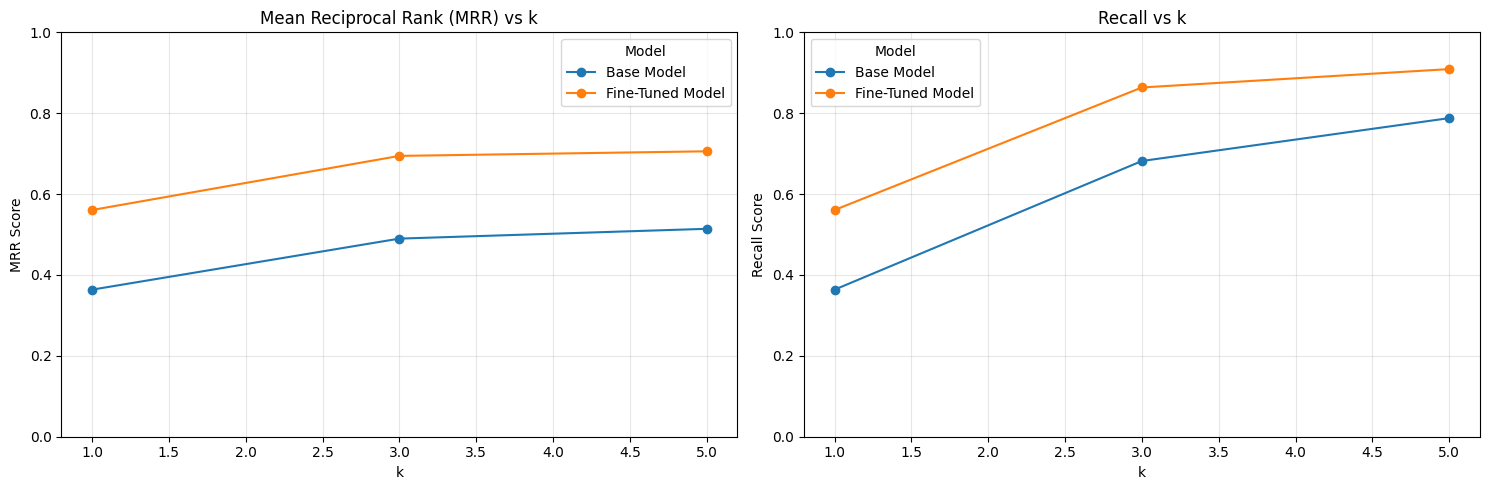

In [20]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Extract k values from column names and convert to numeric
k_values = [int(col.split('@')[1]) for col in df.columns if col.startswith('mrr')]

# Plot MRR values as lines
mrr_cols = [f'mrr@{k}' for k in k_values]
for model in df.index:
    ax1.plot(k_values, df.loc[model, mrr_cols], marker='o', label=model)
ax1.set_title('Mean Reciprocal Rank (MRR) vs k')
ax1.set_xlabel('k')
ax1.set_ylabel('MRR Score')
ax1.legend(title='Model')
ax1.grid(True, alpha=0.3)

# Plot Recall values as lines
recall_cols = [f'recall@{k}' for k in k_values]
for model in df.index:
    ax2.plot(k_values, df.loc[model, recall_cols], marker='o', label=model)
ax2.set_title('Recall vs k')
ax2.set_xlabel('k')
ax2.set_ylabel('Recall Score')
ax2.legend(title='Model')
ax2.grid(True, alpha=0.3)

ax2.set_ylim(0, 1)
ax1.set_ylim(0, 1)

plt.tight_layout()
plt.show()


Through this three-part series, we've explored different approaches to systematically improving RAG systems through fine-tuning.

1. We first explored how to bootstrap a synthetic data from scratch iteratively, leveraging manual annotation and prompting to iteratively improve our model.
2. We then looked at why you might want to consider looking at crossencoders first when data is scarce and why a managed provider like Cohere might be a better starting point than training a model from scratch.
3. Lastly, we explored how fine-tuning an open source embedding model with the `sentence-transformers` library was an easy way to get started but required significantly more low level configuration and hyperparameter tuning.

While managed solutions like Cohere offer faster time-to-production and simplified deployment, open-source models provide greater control and customization potential. The choice between these approaches should be guided by your specific requirements, resources, and the level of performance improvement needed for your use case.